In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from pathlib import Path

import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [2]:
train_dspath = Path('data/train')
test_dspath = Path('data/validation')

list(train_dspath.glob("*"))

for dir_path in train_dspath.glob('*'):
    print(dir_path)
    print(len(list(dir_path.glob('*.jpg'))))

for dir_path in test_dspath.glob('*'):
    print(dir_path)
    print(len(list(dir_path.glob('*.jpg'))))

data\train\alien
347
data\train\predator
347
data\validation\alien
100
data\validation\predator
100


### Preprocessing The images

In [3]:
img_size = 50

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dspath,
  validation_split = None,
  subset = None,
  seed = 123,
  image_size = (img_size, img_size),
  batch_size = 32)

Found 694 files belonging to 2 classes.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dspath,
  validation_split = None,
  subset = None,
  seed = 123,
  image_size = (img_size, img_size),
  batch_size = 32)

Found 200 files belonging to 2 classes.


In [6]:
categories= train_ds.class_names
print(categories)

['alien', 'predator']


### Visualizing Train Images

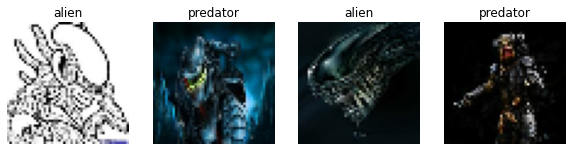

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(categories[labels[i]])
        plt.axis("off")


### Shuffle Train Data

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

### Normalizing Train Data

In [10]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9863629


### Build a model

In [12]:
def Build_model():
    
    model = Sequential()
    
    model.add(Flatten(input_shape=(img_size, img_size, 3)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer= keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
    
    return model

In [13]:
Model = Build_model()
history = Model.fit(train_ds,
          epochs = 15,
          validation_split = None)

C:\Users\user\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
C:\Users\user\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Epoch 1/15
22/22 [==============================] - 0s 5ms/step - loss: 264.5155 - accuracy: 0.5216
Epoch 2/15
22/22 [==============================] - 0s 5ms/step - loss: 55.4699 - accuracy: 0.6354
Epoch 3/15
22/22 [==============================] - 0s 5ms/step - loss: 36.5629 - accuracy: 0.6455
Epoch 4/15
22/22 [==============================] - 0s 5ms/step - loss: 24.3392 - accuracy: 0.7349
Epoch 5/15
22/22 [==============================] - 0s 5ms/step - loss: 18.1317 - accuracy: 0.7507
Epoch 6/15
22/22 [==============================] - 0s 5ms/step - loss: 26.9677 - accuracy: 0.7205
Epoch 7/15
22/22 [==============================] - 0s 6ms/step - loss: 14.5797 - accuracy: 0.7795
Epoch 8/15
22/22 [==============================] - 0s 5ms/step - loss: 15.0200 - accuracy: 0.7853
Epoch 9/15
22/22 [==============================] - 0s 5ms/step - loss: 120.5182 - accuracy: 0.5821
Epoch 10/15
22/22 [==============================] - 0s 5ms/step - loss: 54.4824 - accuracy: 0.6686
Epoch 1

### Loss & Accuracy curves

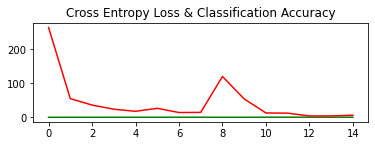

In [14]:
# plot loss
plt.subplot(211)
plt.title('Cross Entropy Loss & Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['loss'], color='red', label='train')

### Save the model

In [15]:
import os.path

if os.path.isfile('Aliens vs.Predators.h5') is False:
    Model.save('Aliens vs.Predators.h5')

### Load the model

In [16]:
from tensorflow.keras.models import load_model

loaded_model = load_model('Aliens vs.Predators.h5')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7500)              0         
                                                                 
 dense (Dense)               (None, 128)               960128    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 964,322
Trainable params: 964,322
Non-trainable params: 0
_________________________________________________________________


### Testing

In [17]:
def Testing(model,test_data):
    test_res = model.evaluate(test_ds)
    print("Accuracy of the model: ",test_res[1])
    return test_res

In [18]:
test_history = Testing(loaded_model,test_ds)

7/7 [==============================] - 0s 3ms/step - loss: 23.1776 - accuracy: 0.6050
Accuracy of the model:  0.6050000190734863


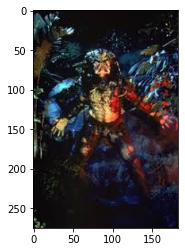

In [19]:
img_path = 'data/validation/predator'

img = tf.keras.preprocessing.image.load_img(img_path+'/1.jpg', target_size=(img_size, img_size))
image=plt.imread(img_path+'/1.jpg')
plt.imshow(image)

In [20]:
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = Model.predict(img_array)
print(categories[np.argmax(predictions)])


predator


In [21]:
print("This image most likely belongs to {} ".format(categories[np.argmax(predictions)]))

This image most likely belongs to predator 


### Confusion Matrix

# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# actual values
actual = [1,0,0,1,0,0,1,0,0,1]
# predicted values
predicted = [1,0,0,1,0,0,0,1,0,0]

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=[1,0])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual,predicted,labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix)

### ROC Curve

from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(true_values, predicted_values, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
plt.plot(fpr, tpr, lw=lw, label=f'ROC curve (area = {roc_auc: 0.2f})')

plt.xlabel('(1–Specificity) - False Positive Rate')
plt.ylabel('Sensitivity - True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()